In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # GPU index
print(torch.cuda.get_device_name(0))  # GPU name

# Directory paths
train_images_path = '/kaggle/input/uiebgan/raw-890'
train_cleaned_path = '/kaggle/input/uiebgan/reference-890'
test_images_path = '/kaggle/input/uiebgan/challenging-60'
save_cleaned_path = '/kaggle/working/cleanedTestImages'
model_save_path = '/kaggle/working/gan_model.pth'

def imshow(tensor, num_images=5):
    grid = make_grid(tensor[:num_images], nrow=num_images)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

# Create save path for cleaned test images
os.makedirs(save_cleaned_path, exist_ok=True)


True
0
Tesla P100-PCIE-16GB


In [ ]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ApplyTransformations:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, input_image, target_filename):
        target_path = os.path.join(train_cleaned_path, target_filename)
        target_image = Image.open(target_path).convert("RGB")

        # Apply the same transformations to both input and target image
        seed = random.random()
        # Apply random transformations using the seed for reproducibility
        random.seed(seed)
        input_image = self.transform(input_image)
        
        random.seed(seed)
        target_image = self.transform(target_image)

        return input_image, target_image


# Define the transformations for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),        # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.5),   
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)), 
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

apply_transform = ApplyTransformations(train_transform)

class ImageDataset(Dataset):
    def __init__(self, input_dir, target_dir=None, transform=None, augment_count=5, num_samples=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.augment_count = augment_count  # Number of augmented versions per image
        
        # Get all files
        self.input_files = sorted(os.listdir(input_dir))
        
        if target_dir:
            self.target_files = sorted(os.listdir(target_dir))
        
        # Randomly sample 'num_samples' files if specified
        if num_samples:
            sampled_indices = random.sample(range(len(self.input_files)), num_samples)
            self.input_files = [self.input_files[i] for i in sampled_indices]
            if target_dir:
                self.target_files = [self.target_files[i] for i in sampled_indices]
    
    def __len__(self):
        # Multiply the length of the dataset by the augment_count to generate multiple versions per image
        return len(self.input_files) * self.augment_count

    def __getitem__(self, idx):
        # Get the original image index (using modulus to cycle through the images)
        orig_idx = idx % len(self.input_files)
        
        input_path = os.path.join(self.input_dir, self.input_files[orig_idx])
        input_image = Image.open(input_path).convert("RGB")
        
        if self.transform:
            input_image, target_image = self.transform(input_image, self.target_files[orig_idx])
        
        return input_image, target_image


# Load data
train_dataset = ImageDataset(train_images_path, train_cleaned_path, transform=apply_transform, augment_count=5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

test_dataset = ImageDataset(test_images_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
     

In [ ]:
# GAN Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
        )
        
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=6):
        super(Generator, self).__init__()
        # Initial convolution
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Downsampling
        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        # Residual blocks
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(num_residual_blocks)]
        )
        # Upsampling
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.initial(x)
        x = self.downsample(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        return self.final(x)



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).mean(dim=(2, 3)).squeeze(1)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))

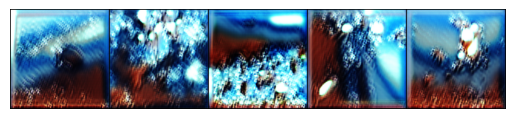

Epoch [10/200], D Loss: 1.2668, G Loss: 1.2031


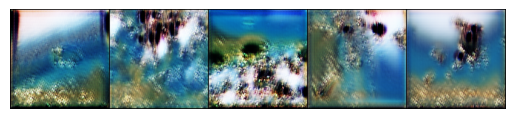

Epoch [20/200], D Loss: 1.2001, G Loss: 1.4150


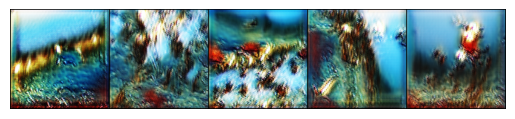

Epoch [30/200], D Loss: 1.1229, G Loss: 1.0271


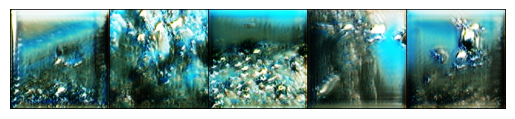

Epoch [40/200], D Loss: 1.3087, G Loss: 0.9084


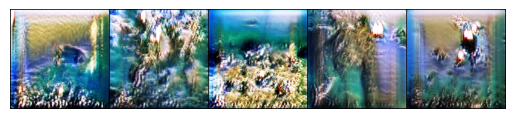

Epoch [50/200], D Loss: 1.2154, G Loss: 1.1841


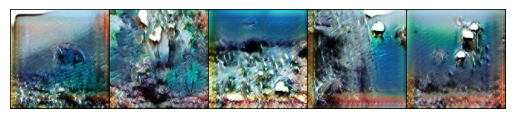

Epoch [60/200], D Loss: 1.3810, G Loss: 1.0492


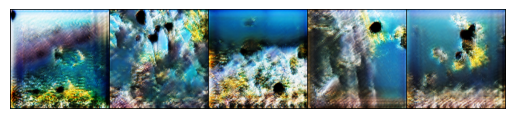

Epoch [70/200], D Loss: 1.0442, G Loss: 1.1984


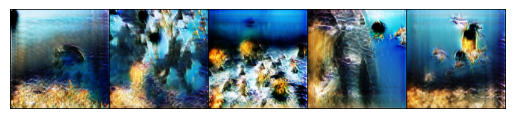

Epoch [80/200], D Loss: 1.1605, G Loss: 1.2296


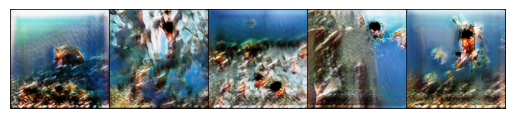

Epoch [90/200], D Loss: 1.2891, G Loss: 1.1768


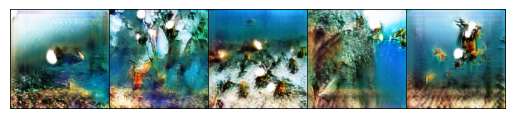

Epoch [100/200], D Loss: 1.1096, G Loss: 1.1472


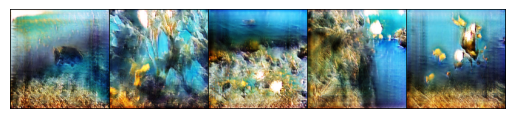

Epoch [110/200], D Loss: 1.1315, G Loss: 1.4228


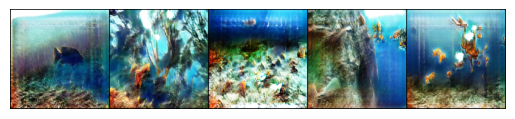

Epoch [120/200], D Loss: 0.9407, G Loss: 1.2690


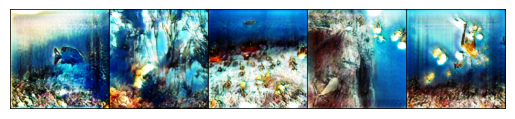

Epoch [130/200], D Loss: 0.9603, G Loss: 1.2460


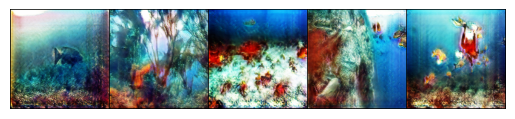

Epoch [140/200], D Loss: 0.8808, G Loss: 1.1001


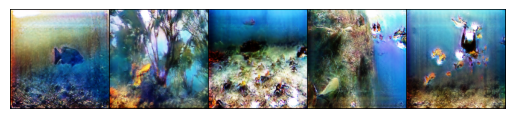

Epoch [150/200], D Loss: 0.9278, G Loss: 1.2189


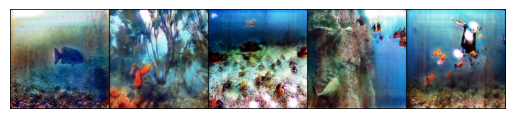

Epoch [160/200], D Loss: 0.9472, G Loss: 1.3707


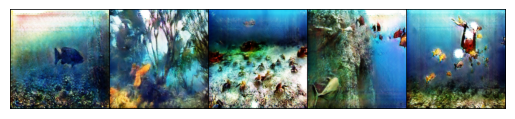

Epoch [170/200], D Loss: 1.0165, G Loss: 1.4148


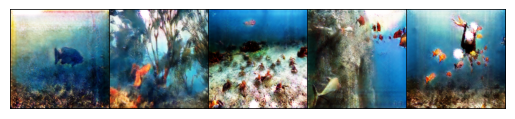

Epoch [180/200], D Loss: 0.9684, G Loss: 1.2016


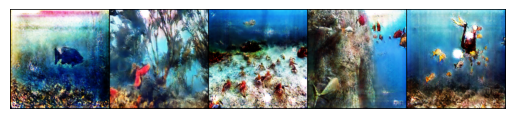

Epoch [190/200], D Loss: 0.9722, G Loss: 1.3408


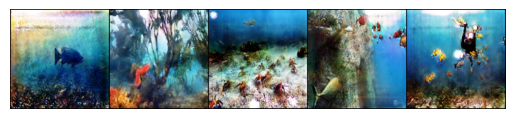

Epoch [200/200], D Loss: 1.0344, G Loss: 1.1488


In [4]:
# Training the GAN
epochs = 200
from tqdm import tqdm 
for epoch in range(epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
    
    for i, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(inputs.size(0), device=device)
        fake_labels = torch.zeros(inputs.size(0), device=device)


        outputs = discriminator(targets)
        real_loss = criterion(outputs, real_labels)
    
        fake_images = generator(inputs)
        outputs = discriminator(fake_images.detach())
        fake_loss = criterion(outputs, fake_labels)

        d_loss = (real_loss + fake_loss)
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()
        progress_bar.set_postfix({"D Loss": d_loss.item(), "G Loss": g_loss.item()})
        
    if (epoch + 1) % 10 == 0:  # Adjust this to visualize less frequently
        print(f"Epoch [{epoch + 1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        with torch.no_grad():
            images_to_display = []
            for i, input_image in enumerate(test_loader):
                input_image = input_image[0].unsqueeze(0).to(device)  # Since test_loader only returns inputs
                cleaned_image = generator(input_image).cpu()
                images_to_display.append(cleaned_image)

                # Display only the first 5 cleaned images
                if i == 9:  # Display only 5 images
                    break

            imshow(torch.cat(images_to_display), num_images=5)




In [5]:
model_save_path = './gan_model_EPOCH_200.pth'
torch.save(generator.state_dict(), model_save_path)

In [6]:
# Testing and saving cleaned images
generator.eval()
with torch.no_grad():
    for i, input_image in enumerate(test_loader):
        input_image = input_image.to(device)
        cleaned_image = generator(input_image)

        input_image = input_image.cpu().squeeze(0)
        cleaned_image = cleaned_image.cpu().squeeze(0)

        input_image_path = os.path.join(save_cleaned_path, f"input_{i + 1}.png")
        cleaned_image_path = os.path.join(save_cleaned_path, f"cleaned_{i + 1}.png")

        save_image(input_image, input_image_path)
        save_image(cleaned_image, cleaned_image_path)

print("Testing complete. Cleaned images saved.")


Testing complete. Cleaned images saved.


In [8]:
!zip -r file.zip /kaggle/working/cleanedTestImages

  adding: kaggle/working/cleanedTestImages/ (stored 0%)
  adding: kaggle/working/cleanedTestImages/input_51.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/input_26.png (stored 0%)
  adding: kaggle/working/cleanedTestImages/input_55.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/input_27.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/input_48.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/input_45.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/cleaned_44.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/cleaned_53.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/cleaned_54.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/input_1.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/cleaned_7.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/cleaned_16.png (deflated 0%)
  adding: kaggle/working/cleanedTestImages/cleaned_26.png (deflated 0%)
  adding: kaggle/working/c